In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install datasets

In [4]:
!git clone 'https://huggingface.co/datasets/wmt16'

Cloning into 'wmt16'...
fatal: unable to access 'https://huggingface.co/datasets/wmt16/': Could not resolve host: huggingface.co


In [1]:
# Import necessary libraries
import torch
import math
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BertTokenizer
from torch.optim import Adam
from tqdm import tqdm
import evaluate

# Load datasets
train_dataset = load_dataset('wmt16', 'de-en', split='train[:50000]')
valid_dataset = load_dataset('wmt16', 'de-en', split='validation')
test_dataset = load_dataset('wmt16', 'de-en', split='test')

#special symbols
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
de_tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
en_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def tokenize_and_numericalize(example):
    src_tokens = de_tokenizer.tokenize(example['translation']['de'])
    tgt_tokens = en_tokenizer.tokenize(example['translation']['en'])
    src_indices = de_tokenizer.convert_tokens_to_ids(src_tokens)
    tgt_indices = en_tokenizer.convert_tokens_to_ids(tgt_tokens)
    return src_indices, tgt_indices

train_data = [(tokenize_and_numericalize(example)) for example in train_dataset]
valid_data = [(tokenize_and_numericalize(example)) for example in valid_dataset]
test_data = [(tokenize_and_numericalize(example)) for example in test_dataset]

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = [torch.tensor(src, dtype=torch.long) for src in src_batch]
    tgt_batch = [torch.tensor(tgt, dtype=torch.long) for tgt in tgt_batch]
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

/opt/homebrew/lib/python3.10/site-packages/datasets/load.py:926: FutureWarning: The repository for wmt16 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at wmt16/wmt16.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/datasets/load.py:926: FutureWarning: The repository for wmt16 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at wmt16/wmt16.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
# Device to mps
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Device to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# model architecture
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model) -> (max_len, d_model, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, d_model]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class Seq2SeqTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout)
        self.generator = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        output = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_key_padding_mask, tgt_key_padding_mask, memory_key_padding_mask)
        output = self.generator(output)
        return output

# Hyperparameters
SRC_VOCAB_SIZE = de_tokenizer.vocab_size
TGT_VOCAB_SIZE = en_tokenizer.vocab_size
D_MODEL = 512
NHEAD = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 2048
DROPOUT = 0.1
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
NUM_EPOCHS = 5

# Instantiate model, optimizer, and loss function
model = Seq2SeqTransformer(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, D_MODEL, NHEAD, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, DIM_FEEDFORWARD, DROPOUT)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
# Training loop
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

train_losses = []
valid_losses = []

model.to(device)
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for src, tgt in tqdm(train_loader):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        optimizer.zero_grad()
        output = model(src, tgt_input, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask)
        output_dim = output.shape[-1]
        output = output.view(-1, output_dim)
        tgt = tgt[1:].view(-1)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in tqdm(valid_loader):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            output = model(src, tgt_input, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask)
            output_dim = output.shape[-1]
            output = output.view(-1, output_dim)
            tgt = tgt[1:].view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item()
    valid_loss = total_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}: Train Loss {train_loss}, Valid Loss {valid_loss}")

  0%|          | 0/6250 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 272/272 [00:03<00:00, 89.99it/s] 


Epoch 1: Train Loss 5.324976616096497, Valid Loss 6.958746100173277


100%|██████████| 272/272 [00:03<00:00, 89.09it/s]


Epoch 2: Train Loss 4.392432124614715, Valid Loss 6.7838762455126815


100%|██████████| 272/272 [00:03<00:00, 89.86it/s] 


Epoch 3: Train Loss 3.9349386335754395, Valid Loss 6.6936891394502975


100%|██████████| 272/272 [00:03<00:00, 90.54it/s]


Epoch 4: Train Loss 3.5886838235569, Valid Loss 6.689781148644054


100%|██████████| 272/272 [00:03<00:00, 90.47it/s] 

Epoch 5: Train Loss 3.3083022369766235, Valid Loss 6.685716492288253


In [5]:
# Save model
torch.save(model.state_dict(), "model2A.pth")

In [4]:
# Load model
model = Seq2SeqTransformer(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, D_MODEL, NHEAD, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, DIM_FEEDFORWARD, DROPOUT)
model.load_state_dict(torch.load("model2A.pth", map_location=torch.device('cpu')))
model.to(device)

/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Seq2SeqTransformer(
  (src_tok_emb): Embedding(30000, 512)
  (tgt_tok_emb): Embedding(28996, 512)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, el

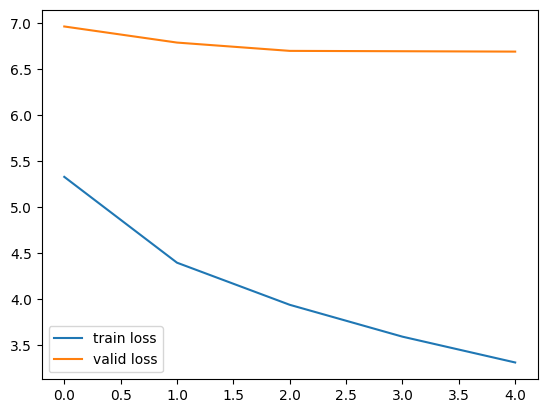

In [6]:
# Plotting the graph
from matplotlib import pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend()
plt.show()

In [5]:
def generate_translations_2a(german_sentence, model_2a):
    model_2a.eval()  # Ensure the model is in evaluation mode.

    # Tokenize German sentence
    src_tokens = de_tokenizer.tokenize(german_sentence)
    src_indices = de_tokenizer.convert_tokens_to_ids(src_tokens)

    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(1).to(device)
    tgt_tensor = torch.tensor([[BOS_IDX]], dtype=torch.long).to(device)

    # Accumulate tokens of the translation here
    generated_tokens = []

    with torch.no_grad():
        # We don't know the sentence length, so we assume some max_length to stop at.
        for _ in range(100):  # Max length
            output = model_2a(src_tensor, tgt_tensor)
            next_token_id = output.argmax(dim=-1)[-1, :].item()  # Take the most likely next token ID
            if next_token_id == EOS_IDX:
                break  # Stop if EOS token is generated
            generated_tokens.append(next_token_id)
            tgt_tensor = torch.cat((tgt_tensor, torch.tensor([[next_token_id]], dtype=torch.long).to(device)), dim=0)

    # Decode the generated tokens into a string, skipping special tokens like EOS or BOS
    translation_2a = en_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return translation_2a

generate_translations_2a("Wiederaufnahme der Sitzungsperiode", model)

'session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session. session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session of the session. session. session. session. session. session'

In [11]:
!pip3 install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 834.8 kB/s eta 0:00:000:00:010m


In [6]:
# Getting bleu score
validation_refs = [valid_dataset[i]["translation"]["de"] for i in range(len(valid_dataset[:5000]))]
validation_translations = [generate_translations_2a(valid_dataset[i]["translation"]["de"], model) for i in range(len(valid_dataset[:5000]))]

test_refs = [test_dataset[i]["translation"]["de"] for i in range(len(test_dataset[:5000]))]
test_translations = [generate_translations_2a(test_dataset[i]["translation"]["de"], model) for i in range(len(test_dataset[:5000]))]

bleu = evaluate.load("bleu")
results_1 = bleu.compute(predictions=validation_translations, references=validation_refs, max_order=1)
results_2 = bleu.compute(predictions=test_translations, references=test_refs, max_order=1)
print("Val: ", results_1)
print("Test: ", results_2)

Val:  {'bleu': 0.02, 'precisions': [0.02], 'brevity_penalty': 1.0, 'length_ratio': 10.0, 'translation_length': 100, 'reference_length': 10}
Test:  {'bleu': 0.0, 'precisions': [0.0], 'brevity_penalty': 1.0, 'length_ratio': 31.0, 'translation_length': 93, 'reference_length': 3}


In [7]:
bertscore = evaluate.load("bertscore")
results1 = bertscore.compute(predictions=validation_translations, references=validation_refs, model_type="distilbert-base-uncased")
results2 = bertscore.compute(predictions=test_translations, references=test_refs, model_type="distilbert-base-uncased")
print("Val: ", results1)
print("Test: ", results2)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Val:  {'precision': [0.6361724138259888], 'recall': [0.6481119394302368], 'f1': [0.6420866847038269], 'hashcode': 'distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.37.2)'}
Test:  {'precision': [0.6335083842277527], 'recall': [0.6447191834449768], 'f1': [0.639064610004425], 'hashcode': 'distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.37.2)'}


In [8]:
meteor = evaluate.load('meteor')
results1 = meteor.compute(predictions=validation_translations, references=validation_refs)
results2 = meteor.compute(predictions=test_translations, references=test_refs)
print("Val: ", results1)
print("Test: ", results2)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arorashivoy/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arorashivoy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/arorashivoy/nltk_data...


Val:  {'meteor': 0.052631578947368425}
Test:  {'meteor': 0.0}
